# Frequency-Wavenumber spectra of kinetic energy in eNATL60 simulation with tides and no tides in ACORES region

__author__ : Aurélie Albert, Julien Le Sommer (MEOM), Andy Hogg (ANU)

__context__ : paper "On the momentum flux of internal tides" by Shakespeare & Hogg

__date__ : March 2019

__practical steps__ :

  * Input data are hourly surface currents from eNATL60-BLB002 simulation (no-tide) and eNTAL60-BLBT02 simulation (tide) 
  
  * A small box in the Acores region is defined to perform the analysis : (31°W-28°W x 33°N-36°N)
  
  * Both surface u and v are detrended and interpolated on a regular grid, and temporal and spatial spectral are computed
  
  * Results are half-summed to get the spectra for Kinetic Energy
  
  * Results are shown in a frequency-wavenumber plots in log-log
  
  
__external libraries needed to run this script__ : 

  * multi-dimensional signal processing tools https://github.com/serazing/xscale by Guillaume Sérazin, UNSW
  
  * methods and tools for wavenumber spectrum  https://github.com/adeajayi-kunle/PowerSpec by Adekunle Ajayi, IGE

 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [51]:
## path for mdules

import xarray as xr
import sys
sys.path.insert(0,"/home/albert/lib/python")

import numpy as np
sys.path.insert(0,"/home/albert/Work/git/xscale")
import xscale
import xscale.spectral.fft as xfft
from matplotlib.colors import LogNorm
import cmocean
import matplotlib.pylab as plt

sys.path.insert(0,"/home/albert/lib/python/w_k_scripts")
import Wavenum_freq_spec_func as wfs

In [3]:
## Dataset

dirtide="/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-BLBT02-S/1h/ACO/"
dirnotide="/mnt/albert/equipes/IGE/meom/MODEL_SET/eNATL60/eNATL60-BLB002-S/1h/ACO/"



In [4]:
filesUtide="eNATL60ACO-BLBT02_1h_*_gridU-2D_*.nc"
filesVtide="eNATL60ACO-BLBT02_1h_*_gridV-2D_*.nc"

tfilesUtide=dirtide+filesUtide
tfilesVtide=dirtide+filesVtide

filesUnotide="eNATL60ACO-BLB002_1h_*_gridU-2D_*.nc"
filesVnotide="eNATL60ACO-BLB002_1h_*_gridV-2D_*.nc"

tfilesUnotide=dirnotide+filesUnotide
tfilesVnotide=dirnotide+filesVnotide


In [18]:
fUtide = xr.open_mfdataset(tfilesUtide)
Utide=fUtide['sozocrtx'][:]
navlat= fUtide['nav_lat']
navlon= fUtide['nav_lon']

fUnotide = xr.open_mfdataset(tfilesUnotide)
Unotide=fUnotide['sozocrtx'][:]

fVtide = xr.open_mfdataset(tfilesVtide)
Vtide=fVtide['somecrty'][:]

fVnotide = xr.open_mfdataset(tfilesVnotide)
Vnotide=fVnotide['somecrty'][:]


In [19]:
box=(-31,-28,33,36)
domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
where=np.where(domain)

lats=navlat[where]
lons=navlon[where]


In [23]:

ind = np.unravel_index(np.argmin(lats, axis=None), lats.shape)
jmin = where[0][ind[0]]
ind = np.unravel_index(np.argmax(lats, axis=None), lats.shape)
jmax = where[0][ind[0]]
ind = np.unravel_index(np.argmin(lons, axis=None), lons.shape)
imin = where[1][ind[1]]
ind = np.unravel_index(np.argmax(lons, axis=None), lons.shape)
imax = where[1][ind[1]]

Utidebox=Utide[:,jmin:jmax+1,imin:imax+1]
Unotidebox=Unotide[:,jmin:jmax+1,imin:imax+1]
Vtidebox=Vtide[:,jmin:jmax+1,imin:imax+1]
Vnotidebox=Vnotide[:,jmin:jmax+1,imin:imax+1]



In [24]:
Utidebox

<xarray.DataArray 'sozocrtx' (time_counter: 744, y: 216, x: 180)>
dask.array<shape=(744, 216, 180), dtype=float32, chunksize=(24, 216, 180)>
Coordinates:
    nav_lat        (y, x) float32 33.01061 33.01062 33.01063 33.010643 ...
    nav_lon        (y, x) float32 -30.994661 -30.977976 -30.961288 ...
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(744,), chunksize=(24,)>
  * time_counter   (time_counter) datetime64[ns] 2009-07-10T00:30:00 ...
Dimensions without coordinates: y, x
Attributes:
    long_name:           ocean surface current along i-axis
    units:               m/s
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

In [40]:
dx,dy = wfs.get_dx_dy(Utidebox[0])
Utide_No_NaN = Utidebox.interpolate_na(dim='y')
Utide_dtr = wfs.detrendn(Utide_No_NaN,axes=[0,1,2])
Utide_wdw = wfs.apply_window(Utide_dtr, Utide_dtr.dims, window_type='hanning')
Utidehat = xfft.fft(Utide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Utide_psd = xfft.psd(Utidehat)
Utide_frequency,kx,ky = wfs.get_f_kx_ky(Utidehat)
Utide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Utide_psd_np = Utide_psd.values
Utide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,wavenumber,Utide_psd_np)


0
100
200
300
400
500
600
700


In [41]:
dx,dy = wfs.get_dx_dy(Vtidebox[0])
Vtide_No_NaN = Vtidebox.interpolate_na(dim='y')
Vtide_dtr = wfs.detrendn(Vtide_No_NaN,axes=[0,1,2])
Vtide_wdw = wfs.apply_window(Vtide_dtr, Vtide_dtr.dims, window_type='hanning')
Vtidehat = xfft.fft(Vtide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Vtide_psd = xfft.psd(Vtidehat)
Vtide_frequency,kx,ky = wfs.get_f_kx_ky(Vtidehat)
Vtide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Vtide_psd_np = Vtide_psd.values
Vtide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,wavenumber,Vtide_psd_np)


0
100
200
300
400
500
600
700


In [42]:
dx,dy = wfs.get_dx_dy(Vnotidebox[0])
Vnotide_No_NaN = Vnotidebox.interpolate_na(dim='y')
Vnotide_dtr = wfs.detrendn(Vnotide_No_NaN,axes=[0,1,2])
Vnotide_wdw = wfs.apply_window(Vnotide_dtr, Vnotide_dtr.dims, window_type='hanning')
Vnotidehat = xfft.fft(Vnotide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Vnotide_psd = xfft.psd(Vnotidehat)
Vnotide_frequency,kx,ky = wfs.get_f_kx_ky(Vnotidehat)
Vnotide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Vnotide_psd_np = Vnotide_psd.values
Vnotide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,wavenumber,Vnotide_psd_np)


0
100
200
300
400
500
600
700
800
900


In [43]:
dx,dy = wfs.get_dx_dy(Unotidebox[0])
Unotide_No_NaN = Unotidebox.interpolate_na(dim='y')
Unotide_dtr = wfs.detrendn(Unotide_No_NaN,axes=[0,1,2])
Unotide_wdw = wfs.apply_window(Unotide_dtr, Unotide_dtr.dims, window_type='hanning')
Unotidehat = xfft.fft(Unotide_wdw, dim=('time_counter', 'x', 'y'), dx={'x': dx, 'y': dx}, sym=True)
Unotide_psd = xfft.psd(Unotidehat)
Unotide_frequency,kx,ky = wfs.get_f_kx_ky(Unotidehat)
Unotide_wavenumber,kradial = wfs.get_wavnum_kradial(kx,ky)
Unotide_psd_np = Unotide_psd.values
Unotide_wavenum_freq_spectrum = wfs.get_f_k_in_2D(kradial,wavenumber,Unotide_psd_np)


0
100
200
300
400
500
600
700
800
900


In [44]:
KEtide_wavenum_freq_spectrum=0.5*(Utide_wavenum_freq_spectrum+Vtide_wavenum_freq_spectrum)
KEnotide_wavenum_freq_spectrum=0.5*(Unotide_wavenum_freq_spectrum+Vnotide_wavenum_freq_spectrum)

In [53]:
KEtide_wavenum_freq_spectrum.shape

(744, 105)

In [54]:
Unotide_wavenumber.shape

(105,)

In [56]:
Utide_frequency.shape

(744,)

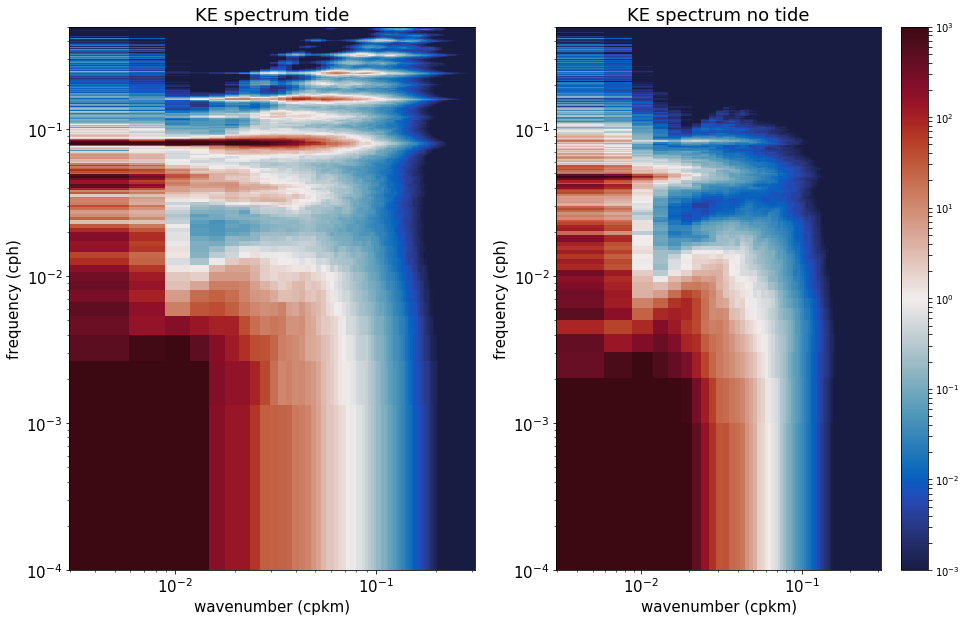

In [66]:
sec_to_hour = 3600.0
norm = LogNorm(vmin=0.001,vmax=1000)
cmap = cmocean.cm.balance

fig,axs=plt.subplots(1,2,figsize=(16,10))
axs[0].pcolormesh(Utide_wavenumber,sec_to_hour*Utide_frequency,KEtide_wavenum_freq_spectrum,norm=norm,cmap=cmap)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel('wavenumber (cpkm)',fontsize=15)
axs[0].set_ylabel('frequency (cph)',fontsize=15)
axs[0].set_xlim(Utide_wavenumber.min(),Utide_wavenumber.max())
axs[0].set_ylim(1E-4,5E-1)
axs[0].set_title('KE spectrum tide',size=18)
axs[0].tick_params(labelsize=15)

a0=axs[1].pcolormesh(Unotide_wavenumber,sec_to_hour*Unotide_frequency,KEnotide_wavenum_freq_spectrum,norm=norm,cmap=cmap)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel('wavenumber (cpkm)',fontsize=15)
axs[1].set_ylabel('frequency (cph)',fontsize=15)
axs[1].set_xlim(Unotide_wavenumber.min(),Unotide_wavenumber.max())
axs[1].set_ylim(1E-4,5E-1)
axs[1].set_title('KE spectrum no tide',size=18)
axs[1].tick_params(labelsize=15)
fig.colorbar(a0)